In [1]:
import numpy as np
import cv2
import math
import os
from matplotlib import pyplot as plt

In [2]:
def calculate_hs_histogram(img, bin_size):
    height, width, _ = img.shape
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    max_h = 179
    max_s = 255
    hs_hist = np.zeros((math.ceil(max_h+1/bin_size), math.ceil(max_s+1/bin_size)))
    for i in range(height):
        for j in range(width):
            h = img_hsv[i, j, 0]
            s = img_hsv[i, j, 1]
            hs_hist[math.floor(h/bin_size), math.floor(s/bin_size)] += 1
    hs_hist /= hs_hist.sum()
    return hs_hist

def color_segmentation(img, hs_hist, bin_size, threshold):
    height, width, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = np.zeros((height, width, 1))
    for i in range(height):
        for j in range(width):
            h = hsv[i, j, 0]
            s = hsv[i, j, 1]
            if hs_hist[math.floor(h/bin_size), math.floor(s/bin_size)] > threshold:
                mask[i, j, 0] = 1
    return mask

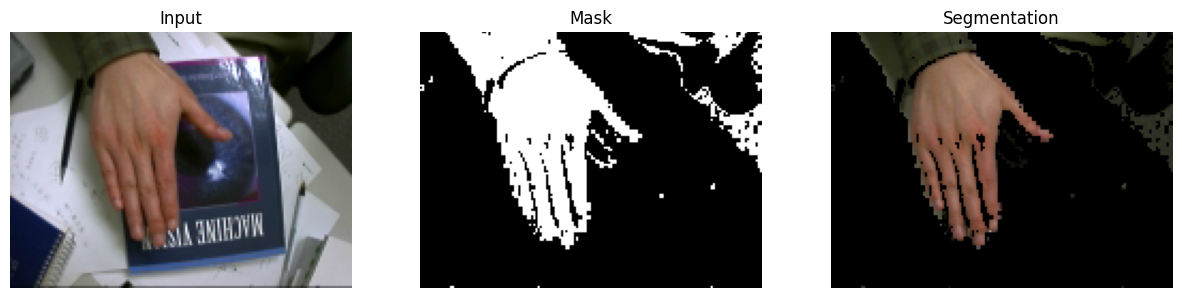

In [3]:
# Compute hs_hist for each image that starts with "skin" in the folder imgs
folder_path = "imgs"
bin_size = 50
hs_hist = np.zeros((math.ceil(179+1/bin_size), math.ceil(255+1/bin_size)))
k = 5
count = 0

# Downsample the image by a factor of 25
for filename in sorted(os.listdir(folder_path)):
    if filename.startswith("skin") and filename.endswith((".png", ".bmp", ".jpg")):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        hs_hist += calculate_hs_histogram(img, bin_size)
        count += 1

hs_hist /= count
# Load test image and perform color segmentation
img_test = cv2.imread("imgs/testing_image.bmp")
threshold = 0.04
mask = color_segmentation(img_test, hs_hist, bin_size, threshold)
img_seg = img_test * mask

# Plot the images using matplotlib
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
ax[0].set_title("Input")
ax[0].axis('off')

ax[1].imshow(mask.squeeze(), cmap='gray')
ax[1].set_title("Mask")
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(img_seg.astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[2].set_title("Segmentation")
ax[2].axis('off')

plt.show()

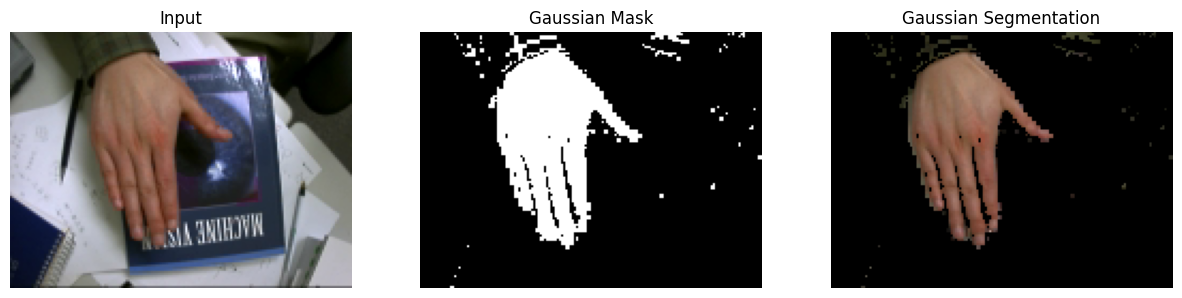

[10.09582314 95.95222367]
[[ 93.28562775  -1.48136753]
 [ -1.48136753 596.34471502]]


In [4]:
# Extract H and S values from the training images
h_values = []
s_values = []

for filename in sorted(os.listdir(folder_path)):
    if filename.startswith("skin") and filename.endswith((".png", ".bmp", ".jpg")):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h_values.extend(img_hsv[:, :, 0].flatten())
        s_values.extend(img_hsv[:, :, 1].flatten())

# Convert to numpy arrays
h_values = np.array(h_values)
s_values = np.array(s_values)

# Estimate the mean vector and covariance matrix
# Compute mean vector manually
mean_h = sum(h_values) / len(h_values)
mean_s = sum(s_values) / len(s_values)
mean_vector = np.array([mean_h, mean_s])

# Compute covariance matrix manually
cov_hh = sum((h - mean_h) ** 2 for h in h_values) / (len(h_values) - 1)
cov_ss = sum((s - mean_s) ** 2 for s in s_values) / (len(s_values) - 1)
cov_hs = sum((h_values[i] - mean_h) * (s_values[i] - mean_s) for i in range(len(h_values))) / (len(h_values) - 1)
cov_matrix = np.array([[cov_hh, cov_hs], [cov_hs, cov_ss]])

# Calculate the skin probability for each pixel in the test image
def calculate_skin_probability(h, s, mean_vector, cov_matrix):
    diff = np.array([h, s]) - mean_vector
    exponent = -0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov_matrix)), diff)
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov_matrix)))

height, width, _ = img_test.shape
img_hsv_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2HSV)
skin_prob = np.zeros((height, width))

for i in range(height):
    for j in range(width):
        h = img_hsv_test[i, j, 0]
        s = img_hsv_test[i, j, 1]
        skin_prob[i, j] = calculate_skin_probability(h, s, mean_vector, cov_matrix)

# Perform segmentation based on the skin probability
threshold = 0.00003
mask_gaussian = (skin_prob > threshold).astype(np.uint8)

# Plot the images using matplotlib
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
ax[0].set_title("Input")
ax[0].axis('off')

ax[1].imshow(mask_gaussian, cmap='gray')
ax[1].set_title("Gaussian Mask")
ax[1].axis('off')

img_seg_gaussian = img_test * mask_gaussian[:, :, np.newaxis]
ax[2].imshow(cv2.cvtColor(img_seg_gaussian.astype(np.uint8), cv2.COLOR_BGR2RGB))
ax[2].set_title("Gaussian Segmentation")
ax[2].axis('off')

plt.show()

print(mean_vector)
print(cov_matrix)

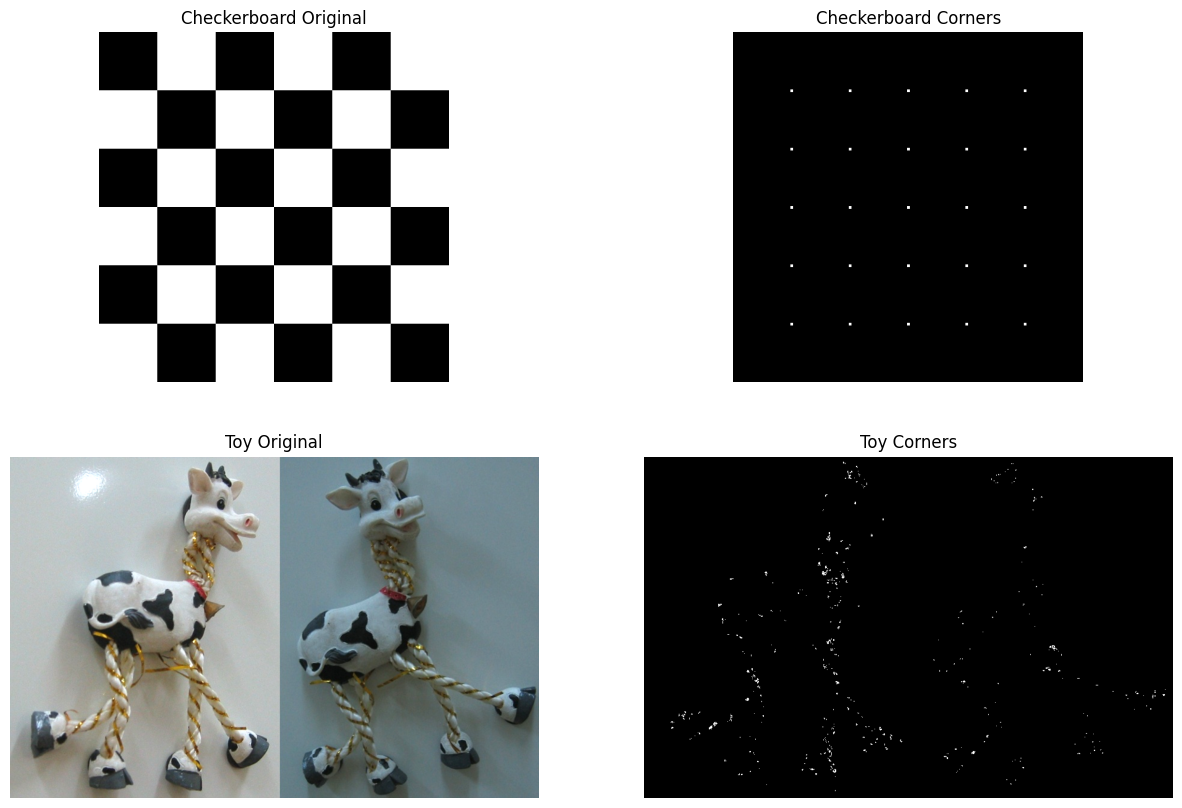

In [5]:
# Load the images
img_checkerboard = cv2.imread('imgs/checkerboard.png')
img_toy = cv2.imread('imgs/toy.png')

# Convert images to grayscale
gray_checkerboard = cv2.cvtColor(img_checkerboard, cv2.COLOR_BGR2GRAY)
gray_toy = cv2.cvtColor(img_toy, cv2.COLOR_BGR2GRAY)

# Detect Harris corners
def detect_harris_corners(gray_img, block_size=2, ksize=3, k=0.04, threshold=0.01):
    gray = np.float32(gray_img)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    img_corners = np.zeros_like(gray_img)
    img_corners[dst > threshold * dst.max()] = 255
    return img_corners

corners_checkerboard = detect_harris_corners(gray_checkerboard)
corners_toy = detect_harris_corners(gray_toy)

# Plot the images with detected corners
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].imshow(cv2.cvtColor(img_checkerboard, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title("Checkerboard Original")
ax[0, 0].axis('off')

ax[0, 1].imshow(corners_checkerboard, cmap='gray')
ax[0, 1].set_title("Checkerboard Corners")
ax[0, 1].axis('off')

ax[1, 0].imshow(cv2.cvtColor(img_toy, cv2.COLOR_BGR2RGB))
ax[1, 0].set_title("Toy Original")
ax[1, 0].axis('off')

ax[1, 1].imshow(corners_toy, cmap='gray')
ax[1, 1].set_title("Toy Corners")
ax[1, 1].axis('off')

plt.show()